#Rozpoznawanie pisma odręcznego (cyfr)
Plik z danymi zawiera zapisaną liczbę (kolumna 'label') oraz wartości pikseli czarno-białego obrazka z odręcznie zapisanymi liczbami. Obrazek ma wymiar 28x28 px. Zbiór danych utworzony ze złączonych ze sobą rzędów pikseli, każdy o wartości z zakresu 0-255, gdzie 255 oznacza czarny.

##Dane początkowe

In [6]:
import pandas as pd

xin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataFiles/DigitRecog_train.csv')
xin.head()
yout = xin['label']
xin.drop('label', axis=1, inplace=True)

In [7]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Split into validation and training data
xTrain, xValid, yTrain, yValid = train_test_split(xin, yout, random_state=1, train_size=0.8, test_size=0.2)

##Funkcje i dane przetworzone

Poniżej znajdują się definicje funkcji określającej część poprawnie odgadniętych cyfr, funkcji binaryzującej oraz przygotowane z ich wykorzystaniem optymalne zbiory danych do uczenia i testowania. Wartość optymalnego progu została określona na podstawie prób przedstawionych w dalszej części projektu.

In [8]:
# Threshold for whole data
def ThresholdPicture(xin, thresholdVal):
  xout = xin.copy()
  for key in xout.values:
    for i in range(len(key)):
      if key[i] > thresholdVal:
        key[i] = 1
      else:
        key[i] = 0
  return xout

# Accuracy for predicted values (percentage)
def GetAccuracy(predicted, validation):
  correct = [y for n, y in enumerate(validation.values)
             if predicted[n] == validation.values[n]]
  accuracy = len(correct) / len(predicted) * 100
  return accuracy

# Array of double -> Array of int
def FloatListToIntList(floatList):
  return [int(round(fl, 0)) for fl in floatList]

# Best result's data
xTrainThBest = ThresholdPicture(xTrain, 0)
xValidThBest = ThresholdPicture(xValid, 0)

##Model drzewa
Podstawowy model do przewidywania na podstawie niezmodyfikowanych danych wejściowych.

In [9]:
treeModel = DecisionTreeRegressor(random_state=1)
treeModel.fit(xTrain, yTrain)

yTree = FloatListToIntList(treeModel.predict(xValid))

mae = mean_absolute_error(yTree, yValid)
accuracyStd = GetAccuracy(yTree, yValid)
print('DRZEWO, OBRAZ ORYGINALNY')
print('Błąd: {}'.format(mae))
print('Trafność: {:.1f}%'.format(accuracyStd))

DRZEWO, OBRAZ ORYGINALNY
Błąd: 0.535
Trafność: 83.1%


W tym najprostszym przypadku została osiągnięta skuteczność powyżej 82%, co wydaje się być trudne do osiągnięcia bez wykorzystywania metod uczenia maszynowego.

##Model drzewa (określone parametry)

DRZEWA


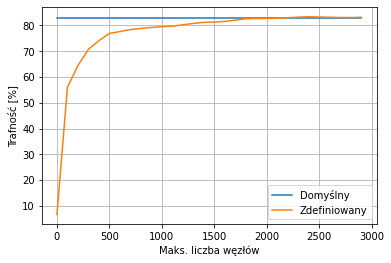

In [10]:
accuracyParam = {}

for i in range(2, 3000, 100):
  paramModel = DecisionTreeRegressor(random_state=1, max_leaf_nodes=i)
  paramModel.fit(xTrain, yTrain)
  yParam = FloatListToIntList(paramModel.predict(xValid))
  accuracyParam[i] = GetAccuracy(yParam, yValid)

# Draw plot
print("DRZEWA")
## Plot data
plotXParam = list(accuracyParam.keys())
plotYParam = list(accuracyParam.values())
plotXStd = plotXParam
plotYStd = [accuracyStd for i in range(len(plotXParam))]
## Figure
plt.plot(plotXStd, plotYStd, plotXParam, plotYParam)
plt.legend(["Domyślny", "Zdefiniowany"], loc="lower right")
plt.xlabel("Maks. liczba węzłów")
plt.ylabel("Trafność [%]")
plt.grid(True)
plt.show()

DRZEWA


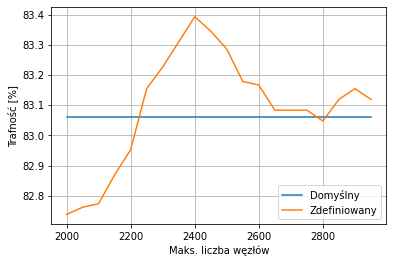

In [11]:
accuracyParam = {}

for i in range(2000, 3000, 50):
  paramModel = DecisionTreeRegressor(random_state=1, max_leaf_nodes=i)
  paramModel.fit(xTrain, yTrain)
  yParam = FloatListToIntList(paramModel.predict(xValid))
  accuracyParam[i] = GetAccuracy(yParam, yValid)

# Draw plot
print("DRZEWA")
## Plot data
plotXParam = list(accuracyParam.keys())
plotYParam = list(accuracyParam.values())
plotXStd = plotXParam
plotYStd = [accuracyStd for i in range(len(plotXParam))]
## Figure
plt.plot(plotXStd, plotYStd, plotXParam, plotYParam)
plt.legend(["Domyślny", "Zdefiniowany"], loc="lower right")
plt.xlabel("Maks. liczba węzłów")
plt.ylabel("Trafność [%]")
plt.grid(True)
plt.show()

Korzyść ze zdefiniowania maksymalnej liczby węzłów jest na tyle niewielka (0,2%), że wiązałaby się jedynie z ryzykiem dopasowania do jednego konkretnego przypadku.

##Dylatacja i erozja
Operacje dylatacji i erozji pozwalają zwężyć lub pogrubić linię, którą rysowana jest cyfra. Operacja pogrubienia (dylatacja) pozwoli na wypełnienie wartością większej ilości pikseli, zmniejszając wielkość tła. Może się w ten sposób zmniejszyć obszar "neutralny", w wyniku czego cyfry będą się od siebie znaczniej róznić.

In [12]:
def GetPictureMin(picture, x, y, width, height):
  minVal = 255
  for x in range(max(0, x - 1), min(width, x + 1)):
    for y in range(max(0, y - 1), min(height, y + 1)):
      minVal = min(minVal, picture[y * width + x])
  return minVal

def GetPictureMax(picture, x, y, width, height):
  maxVal = 0
  for x in range(max(0, x - 1), min(width, x + 1)):
    for y in range(max(0, y - 1), min(height, y + 1)):
      maxVal = max(maxVal, picture[y * width + x])
  return maxVal

def DilatePictures(pictures, width, height):
  result = pictures.copy()
  for (pict, orig) in zip(result.values, pictures.values):
    for x in range(width):
      for y in range(height):
        pict[y * width + x] = GetPictureMax(orig, x, y, width, height)
  return result

def ErodePictures(pictures, width, height):
  result = pictures.copy()
  for (pict, orig) in zip(result.values, pictures.values):
    for x in range(width):
      for y in range(height):
        pict[y * width + x] = GetPictureMin(orig, x, y, width, height)
  return result

xTrainDil = DilatePictures(xTrain, 28, 28)
treeModelDil = DecisionTreeRegressor(random_state=1)
treeModelDil.fit(xTrainDil, yTrain)
yTreeDil = FloatListToIntList(treeModelDil.predict(xValid))
mae = mean_absolute_error(yTreeDil, yValid)
accuracyDil = GetAccuracy(yTreeDil, yValid)
print('DYLATACJA')
print('Błąd: {}'.format(mae))
print('Trafność: {:.1f}%'.format(accuracyDil))

xTrainEro = ErodePictures(xTrain, 28, 28)
treeModelEro = DecisionTreeRegressor(random_state=1)
treeModelEro.fit(xTrainEro, yTrain)
yTreeEro = FloatListToIntList(treeModelEro.predict(xValid))
mae = mean_absolute_error(yTreeEro, yValid)
accuracyEro = GetAccuracy(yTreeEro, yValid)
print('EROZJA')
print('Błąd: {}'.format(mae))
print('Trafność: {:.1f}%'.format(accuracyEro))

DYLATACJA
Błąd: 1.1575
Trafność: 66.3%
EROZJA
Błąd: 1.1167857142857143
Trafność: 64.8%


Wpływ tych operacji jest jednoznacznie negatywny, zatem nie zostaną one wykorzystane.

##Progowanie (binaryzacja)
Sprawdzenie wpływu progu binaryzacji na wyniki przewidywań.

DRZEWO, BINARYZACJA


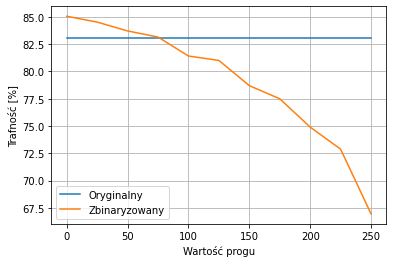

In [13]:
accuracyTh = {}

for i in range(0, 256, 25):
  xTrainTh = ThresholdPicture(xTrain, i)
  xValidTh = ThresholdPicture(xValid, i)

  digitModel = DecisionTreeRegressor(random_state=1)
  digitModel.fit(xTrainTh, yTrain)

  yTreeTh = FloatListToIntList(digitModel.predict(xValidTh))
  accuracyTh[i] = GetAccuracy(yTreeTh, yValid)

# Draw plot
print("DRZEWO, BINARYZACJA")
## Plot data
plotXTh = list(accuracyTh.keys())
plotYTh = list(accuracyTh.values())
plotXStd = plotXTh
plotYStd = [accuracyStd for i in range(len(plotXTh))]
## Figure
plt.plot(plotXStd, plotYStd, plotXTh, plotYTh)
plt.legend(["Oryginalny", "Zbinaryzowany"], loc="lower left")
plt.xlabel("Wartość progu")
plt.ylabel("Trafność [%]")
plt.grid(True)
plt.show()

Wraz ze zwiększaniem progu binaryzacji występuje wyraźna tandencja spadkowa skuteczności. Oznacza to, że najskuteczniejszy jest podział obrazka na tło (o jednej wartości, <code>0</code>) oraz linię cyfry (niezależnie od intensywności piksela). Pominięcie intensywności może być pomocne np. w przypadku, w którym cyfry pisane byłyby różnymi kolorami pisaków. Niewłaściwa binaryzacja znacznie pogarsza skuteczność metody.

##Progowanie (binaryzacja) - szczegóły
Sprawdzone zostały niskie poziomy progowania (o pozytywnym efekcie).

DRZEWO, BINARYZACJA


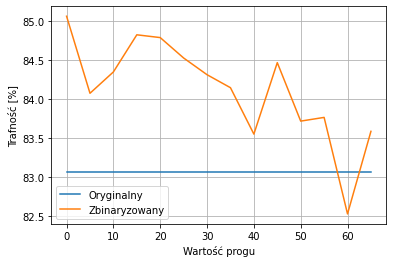

In [14]:
accuracyThZ = {}

for i in range(0, 70, 5):
  xTrainThZ = ThresholdPicture(xTrain, i)
  xValidThZ = ThresholdPicture(xValid, i)

  digitModel = DecisionTreeRegressor(random_state=1)
  digitModel.fit(xTrainThZ, yTrain)

  yTreeThZ = FloatListToIntList(digitModel.predict(xValidThZ))
  accuracyThZ[i] = GetAccuracy(yTreeThZ, yValid)

# Draw plot
print("DRZEWO, BINARYZACJA")
## Plot data
plotXThZ = list(accuracyThZ.keys())
plotYThZ = list(accuracyThZ.values())
plotXStdZ = plotXThZ
plotYStdZ = [accuracyStd for i in range(len(plotXThZ))]
## Figure
plt.plot(plotXStdZ, plotYStdZ, plotXThZ, plotYThZ)
plt.legend(["Oryginalny", "Zbinaryzowany"], loc="lower left")
plt.xlabel("Wartość progu")
plt.ylabel("Trafność [%]")
plt.grid(True)
plt.show()

Skuteczność nie przejawia monotonnej tendencji. Najlepsze osiągi występują bezsprzecznie dla wartości niskiego progu, co wskazuje na jednorodne tło dla zapisanych znaków (o wartości <code>0</code>). Na tej podstawie można się spodziewać, że są to obrazki utworzone elektronicznie lub już poddane wstępnej filtracji.

##Losowy las (z binaryzacją)

In [15]:
# Model definition
forestModel = RandomForestRegressor(random_state=1)

# Model fitting
forestModel.fit(xTrainThBest, yTrain)

# Model prediction
yForest = FloatListToIntList(forestModel.predict(xValidThBest))

# Mean absolute error and accuracy indicators
maeForest = mean_absolute_error(yForest, yValid)
accuracyForest = GetAccuracy(yForest, yValid)
print('LAS (OBRAZ ZBINARYZOWANY)')
print('Błąd: {}'.format(maeForest))
print('Trafność: {:.1f}%'.format(accuracyForest))

LAS (OBRAZ ZBINARYZOWANY)
Błąd: 0.4098809523809524
Trafność: 74.4%


W przypadku zastosowania lasu problemem okazało się, że ze względu na korzystanie z wielu drzew i wyciągnie z nich średniej, wyniki w większym stopniu odbiegały od liczb całkowutych. Po konwersji z zaokrągleniem wprawdzie zmniejszył się błąd, jednak skuteczność rozpoznawania liczb spadła. Oznacza to w tym szczególnym przypadku, że losowy las jest rozwiązaniem gorszym od pojedynczych drzew.

##Losowy las (dane oryginalne)
Ze względu na niski wynik przy zastosowaniu binaryzacji, wykonany został również test dla obrazków nieprzetworzonych.

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Definition of the model
forestModel = RandomForestRegressor(random_state=1)

# Model fitting
forestModel.fit(xTrain, yTrain)

# Model prediction
yForest = FloatListToIntList(forestModel.predict(xValid))

# Mean absolute error and accuracy indicators
maeForest = mean_absolute_error(yForest, yValid)
accuracyForest = GetAccuracy(yForest, yValid)
print('LAS, OBRAZ ORYGINALNY')
print('Błąd: {}'.format(maeForest))
print('Trafność: {:.1f}%'.format(accuracyForest))

LAS, OBRAZ ORYGINALNY
Błąd: 0.46404761904761904
Trafność: 70.9%


Również tym razem liczby zostały wytypowane z mniejszą skutecznością niż przy użyciu samodzielnego drzewa. Wynik pogorszył się o około 3% w stosunku do prób z binaryzacją, co ponownie dowodzi jej skuteczności.

##Korekcja wyników


W tym podejściu najpierw dokonywane są przewidywania metodą losowego lasu, następnie wynik jest poprawiany na podstawie danych wejściowych i wstępnego wyniku. Idea polegała na tym, żeby wyniki wstępne (zmiennoprzecinkowe) były ponownie interpretowane przez inny estymator, który miałby dokonać wyboru (zaokrąglić w górę lub dół).

In [17]:
def SplitToIsN(digits):
  isN = {}
  for i in range(10):
    isN[i] = [1 if d == i else 0 for d in digits]
  return pd.DataFrame(isN, index=digits.index)

def TrainDigitModels(x, y):
  digitModels = {}
  yNum = SplitToIsN(y)
  for i in range(10):
    digitModel = DecisionTreeRegressor(random_state=1)
    digitModel.fit(x, yNum[i])
    digitModels[i] = digitModel
  return digitModels

def TrainChooseModel(isN, y):
  chooseModel = DecisionTreeRegressor(random_state=1)
  chooseModel.fit(isN, y)
  return chooseModel

def PredictIsNTable(x, digitModels):
  preds = {}
  for i in range(10):
    preds[i] = digitModels[i].predict(x)
  return pd.DataFrame(preds, index=x.index)

def ChooseDigits(isN, chooseModel):
  choices = chooseModel.predict(isN)
  digits = [round(ch) for ch in choices]
  return digits #pd.DataFrame(digits, index=isN.index, columns=None)

def PredictDigits(x, digitModels, chooseModel):
  return ChooseDigits(PredictIsNTable(x, digitModels), chooseModel)

def TrainModels(x, y):
  xTrain1, xTrain2, yTrain1, yTrain2 = train_test_split(x, y, random_state=1, train_size=0.5, test_size=0.5)
  # First part of train data
  digitModels1 = TrainDigitModels(xTrain1, yTrain1)
  isN1 = PredictIsNTable(xTrain2, digitModels1)
  # Second part of train data
  digitModels2 = TrainDigitModels(xTrain2, yTrain2)
  isN2 = PredictIsNTable(xTrain1, digitModels1)
  # Train set for choose model
  isNFull = pd.concat([isN1, isN2], axis=0)
  yTrainFull = pd.concat([yTrain1, yTrain2], axis=0)
  # Final models training
  chooseModelFin = TrainChooseModel(isNFull, yTrainFull)
  digitModelsFin = TrainDigitModels(x, y)
  return digitModelsFin, chooseModelFin

digitModels, chooseModel = TrainModels(xTrain, yTrain)
yChoose = PredictDigits(xValid, digitModels, chooseModel)

mae = mean_absolute_error(yChoose, yValid)
accuracyChoose = GetAccuracy(yChoose, yValid)
print('METODA DWUETAPOWA')
print('Błąd: {}'.format(mae))
print('Trafność: {:.1f}%'.format(accuracyChoose))

METODA DWUETAPOWA
Błąd: 2.550952380952381
Trafność: 9.8%


In [18]:
# Split into validation and training data
xTrain1, xTrain2, yTrain1, yTrain2 = train_test_split(xTrain, yTrain, random_state=1, train_size=0.80, test_size=0.20)

predictModel = RandomForestRegressor(random_state=1)
predictModel.fit(xTrain1, yTrain1)
yTrainPredict = predictModel.predict(xTrain2)

xTrainReview = pd.DataFrame(yTrainPredict, index=xTrain2.index, columns=['PrePredict'])
#xTrainEx = pd.concat([xTrain2, ], axis=1)
reviewModel = DecisionTreeRegressor(random_state=1)
reviewModel.fit(xTrainReview, yTrain2)

yValidPredict = predictModel.predict(xValid)
xValidReview = pd.DataFrame(yValidPredict, index=xValid.index, columns=['PrePredict'])
#xValidEx = pd.concat([xValid, pd.Series(yValidPredict, index=xValid.index, name='PrePredict')], axis=1)
yReview = FloatListToIntList(reviewModel.predict(xValidReview))

mae = mean_absolute_error(yReview, yValid)
accuracyReview = GetAccuracy(yReview, yValid)
print('DRZEWO Z KOREKCJĄ')
print('Błąd: {}'.format(mae))
print('Trafność: {:.1f}%'.format(accuracyReview))

DRZEWO Z KOREKCJĄ
Błąd: 0.5046428571428572
Trafność: 69.4%


Rozwiązanie to okazało się zupełnie nieskuteczne. Skuteczniejsze jest pracowanie z jednym estymatorem.

##Model optymalny

In [19]:
xTest = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataFiles/DigitRecog_test.csv')

xAllBest = ThresholdPicture(xin, 0)
bestModel = DecisionTreeRegressor(random_state=1, max_leaf_nodes=2250)
bestModel.fit(xAllBest, yout)

yTestBest = FloatListToIntList(bestModel.predict(xTest))

output = pd.DataFrame({'ImageId': range(1, 28001, 1),
                       'Label': yTestBest})
output.to_csv('/content/drive/MyDrive/Colab Notebooks/dataFiles/digit_recog_submit.csv', index=False)
print('Done.')


Done.


Zaproponowany model osiągnął następujący rezultat:<br>
* skuteczność: 85,3%<br>

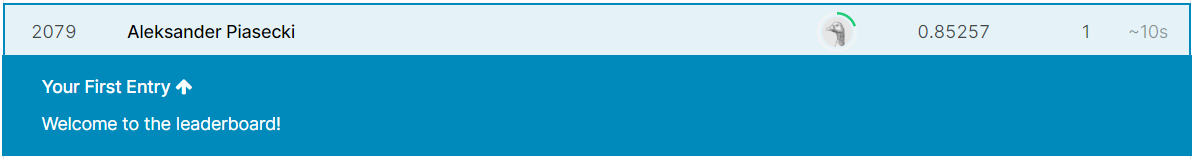<br>
Zgodnie z rozważaniami określenie max_leaf_nodes pogorszyło wynik zbioru konkursowego o 1,5% (83,9%). Ze względu na niewielkie możliwości modyfikacji podejścia, zrealizowany został również inny projekt konkursowy, wymagający bardziej zaawansowanej interpretacji danych.